In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib
import scipy.stats
import matplotlib.gridspec as gridspec
import glob
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

%matplotlib inline

In [2]:
# Pretty Plots
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})
def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [3]:
env = "antmaze-large-play-v2"

In [4]:
mm = []
for s in range(10):
    mm.append([np.load(x, allow_pickle=True)['means'] for x in glob.glob(os.path.join("./learners/{0}".format(env), f'mm_icml_rewards_25_{s}_100.npz'))][0])

In [5]:
mm = np.stack(mm, axis=0)

In [6]:
filt = []
for s in range(10):
    filt.append([np.load(x, allow_pickle=True)['means'] for x in glob.glob(os.path.join("./learners/{0}".format(env), f'filter_br_icml_rewards_25_{s}_100.npz'))][0])

In [7]:
filt = np.stack(filt, axis=0)

In [8]:
filt2 = []
for s in range(10):
    filt2.append([np.load(x, allow_pickle=True)['means'] for x in glob.glob(os.path.join("./learners/{0}".format(env), f'filter_nr_icml_rewards_25_{s}_100.npz'))][0])

In [9]:
filt2 = np.stack(filt2, axis=0)

In [10]:
bc = []
for s in range(10):
    bc.append([np.load(x, allow_pickle=True)['means'] for x in glob.glob(os.path.join("./learners/{0}".format(env), f'bc_icml_rewards_{s}.npz'))][0])

In [11]:
bc = np.stack(bc, axis=0).reshape(-1, 1)

In [12]:
def calc_iqm(data):
    iqm = lambda x: np.array([metrics.aggregate_iqm(x[:, :, i]) for i in range(x.shape[-1])])
    iqm_scores, _ = rly.get_interval_estimates({'alg': np.expand_dims(data, 1)}, iqm, reps=5000)
    return iqm_scores

In [13]:
mm_mean, mm_ci = calc_iqm(mm)['alg'], np.std(mm, axis=0) / np.sqrt(len(mm))

In [14]:
br_mean, br_ci = calc_iqm(filt)['alg'], np.std(filt, axis=0) / np.sqrt(len(filt))

In [15]:
nr_mean, nr_ci = calc_iqm(filt2)['alg'], np.std(filt2, axis=0) / np.sqrt(len(filt2))

In [16]:
bc_mean, bc_ci = calc_iqm(bc * 100)['alg'], np.std(100 * bc.reshape(-1), axis=0) / np.sqrt(len(bc.reshape(-1)))

In [17]:
steps=21
sz=5000 * 5

Text(0.5, 1.0, 'antmaze-large-play-v2, $p_{tremble}=0.0$')

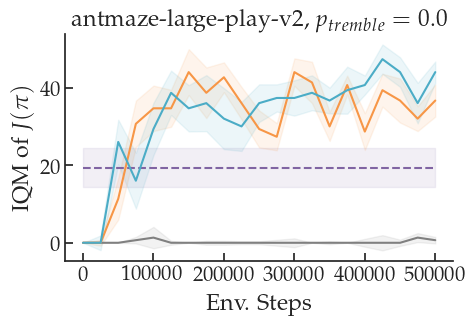

In [18]:
setup_plot()
plt.plot(np.arange(steps) * sz, np.ones(steps) * bc_mean, label="$\\texttt{BC}$", color="#8064A2", linestyle="--")
plt.fill_between(np.arange(steps) * sz,
                  np.ones(steps) * (bc_mean - bc_ci),
                  np.ones(steps) * (bc_mean + bc_ci),
                  color = "#8064A2",
                  alpha = 0.1)
plt.plot(np.arange(steps) * sz, mm_mean, label="$\\texttt{MM}$", color="grey")
plt.fill_between(np.arange(steps) * sz,
                  mm_mean - mm_ci,
                  mm_mean + mm_ci,
                  color = "grey",
                  alpha = 0.1)
plt.plot(np.arange(steps) * sz, nr_mean, label="$\\texttt{FILTER(NR)}$, $\\alpha=1$", color="#F79646")
plt.fill_between(np.arange(steps) * sz,
                  nr_mean - nr_ci,
                  nr_mean + nr_ci,
                  color = "#F79646",
                  alpha = 0.1)
plt.plot(np.arange(steps) * sz, br_mean, label="$\\texttt{FILTER(BR)}$, $\\alpha=1$", color="#4bacc6")
plt.fill_between(np.arange(steps) * sz,
                  br_mean - br_ci,
                  br_mean + br_ci,
                  color = "#4bacc6",
                  alpha = 0.1)
# plt.legend(ncol=2, fontsize=12, loc='upper left', bbox_to_anchor=(0.2, 0.45))
plt.ylabel("IQM of $J(\\pi)$")
plt.xlabel("Env. Steps")
plt.title(f"{env}, " + "$p_{tremble}=0.0$")
# plt.savefig(f"{env}_icml_tremble2.pdf", bbox_inches='tight')